In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import *   #compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units

import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.



In [ ]:
pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


pres = (pres+pres_base)/100.                # hectoPascals
pres = pres.where(sea_mask_modified, drop=False)

del pres_base

In [7]:
# load data
QVAPOR = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
QVAPOR = QVAPOR['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
# QVAPOR_day = QVAPOR.groupby('time_counter.day')

In [8]:
# select data oversea
QVAPOR = QVAPOR.where(sea_mask_modified, drop=False)


In [9]:
# def lon lat time
lon = QVAPOR['nav_lon_grid_M'].values
lat = QVAPOR['nav_lat_grid_M'].values
#lon, lat = np.meshgrid(lon_M, lat_M)

# time = QVAPOR_day['time_counter'].values.astype('<M8[s]')
# time_day = QVAPOR_day['day'].astype('<M8[s]')

In [23]:
### LOAD PRESSURE COLUMN
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

In [6]:
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH['PH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))/9.81


In [7]:
GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask, drop=False)

del GPH_base

In [8]:
'''i = np.arange(0,38)
GPH = 0.5*(GPH[:,i,:,:]+GPH[:,i+1,:,:])

# mean GPH over domain
GPH_mean = GPH.mean(axis=(0,2,3))'''

In [8]:
press_from_GPH = mpcalc.height_to_pressure_std(GPH*units.meters)
del GPH

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

In [13]:
press_diff = np.zeros((232,39,546,573)) #QVAPOR.values)
press_diff = press_from_GPH.values[:,0:-1,:,:] - press_from_GPH.values[:,1:,:,:] 
del press_from_GPH

In [15]:
ds_out_gph = xr.Dataset()

press_from_GPH.attrs['long name'] = 'GPH converted to pressure'
press_from_GPH.attrs['units'] = 'hPa'
ds_out_gph = ds_out_gph.assign(press_from_GPH=press_from_GPH)


press_diff = xr.DataArray(press_diff, name='press_diff', dims=['time_counter', 'lev_M', 'lat', 'lon'])

press_diff.attrs['long name'] = 'vertical thicknesses in pressure'
press_diff.attrs['units'] = 'hPa'
ds_out_gph = ds_out_gph.assign(press_diff=press_diff)

In [17]:
ds_out_gph.to_netcdf('/venus/tesi_ale/data_EU/GPH/daily/FEB/GPH_3h_press.nc')

In [14]:
grams_of_moisture = (QVAPOR*1000.)*press_diff/9.81

In [15]:
grams_of_moisture_day = grams_of_moisture.groupby('time_counter.day').mean()

In [ ]:
# compute daily means
'''pres_day = pres.groupby('time_counter.day').mean()
GPH_day = GPH.groupby('time_counter.day').mean()'''

OPENING HOURLY DATASETS

In [24]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


In [25]:
# daily varaibles
# select sst, q2, U, PBLH

sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False).values;                                          


In [16]:
# compute anomalies daily data
s = 100

# dQVAPOR_day = np.zeros(QVAPOR_day.shape)
dg_moisture_day = np.zeros(grams_of_moisture_day.shape)

for t in range(0,grams_of_moisture_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,grams_of_moisture.shape[1]):
#         q_ave = gm.nan_gaussian_filter(QVAPOR_day[t,h],s)                            
#         dQVAPOR_day[t,h] = QVAPOR_day[t,h] - q_ave

        ave_moi = gm.nan_gaussian_filter(grams_of_moisture_day[t,h].values,s) 
        dg_moisture_day[t,h] = grams_of_moisture_day[t,h] - ave_moi

0
10
20


In [17]:
ds_out = xr.Dataset()

grams_of_moisture.attrs['long name'] = '3h grams of moisture in every cell i.e. QVAPOR*pres.diff()'
grams_of_moisture.attrs['units'] = 'g/m^2'
ds_out = ds_out.assign(grams_qvapor=grams_of_moisture)

grams_of_moisture_day.attrs['long name'] = 'daily grams of moisture in every cell i.e. daily_mean(QVAPOR*pres.diff())'
grams_of_moisture_day.attrs['units'] = 'g/m^2'
ds_out = ds_out.assign(grams_qvapor_day=grams_of_moisture_day)

dg_moisture_out = xr.DataArray(dg_moisture_day, name='dg_moisture_day', dims=['day', 'lev', 'lat', 'lon'])
dg_moisture_out.attrs['long name'] = '200km anomalies of daily grams of moisture in every cell i.e. QVAPOR*pres.diff()'
dg_moisture_out.attrs['units'] = 'g/m^2'

ds_out = ds_out.assign(dg_moisture_day=dg_moisture_out)

In [18]:
ds_out.to_netcdf('/venus/tesi_ale/data_EU/QVAPOR_correct/daily/FEB/grams_of_moisture_correct.nc')

In [ ]:
#####################################################

In [36]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.


In [20]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    f.close()

dsst_day = dsst_day*sea_mask_modified_nan

In [13]:
ds_qvapor = xr.open_dataset('/venus/tesi_ale/data_EU/QVAPOR_correct/daily/FEB/grams_of_moisture_correct.nc')
grams_of_moisture_day = ds_qvapor['grams_qvapor_day']
dg_moisture_day = ds_qvapor['dg_moisture_day']

#### select domain

In [62]:
## DOMAIN SELECTION
mask = open_ocean_mask #sea_mask_modified_nan #tourbillons_mask  # open_ocean_mask

In [63]:
# PERC DISTRIBUTION dQVAPOR vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_sst, pdist_QVAPOR_sst, pstd_QVAPOR_sst, pstderr_QVAPOR_sst, pnpoints_QVAPOR_sst, ppvalue_QVAPOR_sst_sub = \
dist_3d_subsample(sst_day*mask, grams_of_moisture_day.values*mask, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [16]:
ds_sst_qvap = xr.Dataset()
list_vars = [pdist_sst, pdist_QVAPOR_sst, pstd_QVAPOR_sst, pstderr_QVAPOR_sst, pnpoints_QVAPOR_sst, ppvalue_QVAPOR_sst_sub]
name_vars = ['pdist_sst', 'pdist_QVAPOR_sst', 'pstd_QVAPOR_sst', 'pstderr_QVAPOR_sst', 'pnpoints_QVAPOR_sst', 'ppvalue_QVAPOR_sst_sub']

for var, var_name in zip(list_vars, name_vars):
    if var_name=='pdist_sst':
        dims = ['sst']
    else:
        dims = ['pressure', 'sst']
    ds_sst_qvap[var_name] = xr.DataArray(var, name=var_name, dims=dims)


In [17]:
ds_sst_qvap.to_netcdf('/venus/tesi_ale/data_EU/QVAPOR_correct/daily/FEB/pdistrs_sst_qMoisture_NEW.nc')

In [18]:
# PERC DISTRIBUTION dQVAPOR vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_QVAPOR_dsst, pstd_QVAPOR_dsst, pstderr_QVAPOR_dsst, pnpoints_QVAPOR_dsst, ppvalue_QVAPOR_dsst_sub = \
dist_3d_subsample(dsst_day*mask, grams_of_moisture_day.values*mask, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [19]:
ds_dsst_qvap = xr.Dataset()
list_vars = [pdist_dsst, pdist_QVAPOR_dsst, pstd_QVAPOR_dsst, pstderr_QVAPOR_dsst, pnpoints_QVAPOR_dsst, ppvalue_QVAPOR_dsst_sub]
name_vars = ['pdist_dsst', 'pdist_QVAPOR_dsst', 'pstd_QVAPOR_dsst', 'pstderr_QVAPOR_dsst', 'pnpoints_QVAPOR_dsst', 'ppvalue_QVAPOR_dsst_sub']

for var, var_name in zip(list_vars, name_vars):
    if var_name=='pdist_dsst':
        dims = ['sst']
    else:
        dims = ['pressure', 'sst']
    ds_dsst_qvap[var_name] = xr.DataArray(var, name=var_name, dims=dims)


In [20]:
ds_dsst_qvap.to_netcdf('/venus/tesi_ale/data_EU/QVAPOR_correct/daily/FEB/pdistrs_dsst_qMoisture_NEW.nc')

In [77]:
# PERC DISTRIBUTION dQVAPOR vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dQVAPOR_day, pstd_dQVAPOR_day, pstderr_dQVAPOR_day, pnpoints_dQVAPOR, ppvalue_dQVAPOR_day_sub = \
dist_3d_subsample(dsst_day*mask, dg_moisture_day.values*mask, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [23]:
ds_dsst_dqvap = xr.Dataset()
list_vars = [pdist_dsst, pdist_dQVAPOR_day, pstd_dQVAPOR_day, pstderr_dQVAPOR_day, pnpoints_dQVAPOR, ppvalue_dQVAPOR_day_sub]
name_vars = ['pdist_dsst', 'pdist_dQVAPOR_day', 'pstd_dQVAPOR_day', 'pstderr_dQVAPOR_day', 'pnpoints_dQVAPOR', 'ppvalue_dQVAPOR_day_sub']

for var, var_name in zip(list_vars, name_vars):
    if var_name=='pdist_dsst':
        dims = ['sst']
    else:
        dims = ['pressure', 'sst']
    ds_dsst_dqvap[var_name] = xr.DataArray(var, name=var_name, dims=dims)


In [24]:
ds_dsst_dqvap.to_netcdf('/venus/tesi_ale/data_EU/QVAPOR_correct/daily/FEB/pdistrs_dsst_dqMoisture_NEW.nc')

In [26]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False).values;

In [27]:
# PBLH IN PRESSURE VALUES! 
# output is in hPa
PBLH_pres = mpcalc.height_to_pressure_std(PBLH_day*units.meters)
PBLH_pres = PBLH_pres.magnitude #.m_as('hPa')

In [31]:
# DISTRIBUTION PBLH vs dSST bin - DAILY 
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

#  PBLH distrib

# perc
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstderr_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')


In [30]:
# DISTRIBUTION PBLH vs dSST bin - DAILY 
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

#  PBLH distrib

# perc
pdist_sst, pdist_PBLH_sst, pstd_PBLH_sst, pstderr_PBLH_sst, pnpoints_PBLH_sst, ppvalue_PBLH_sst = \
distrib_2d(sst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')

/venus/tesi_ale/img_EU/QVAPOR_correct/daily/FEB/NEW_pdist_dsst_dqMoisture_lowtropo_2pc_NEW.png


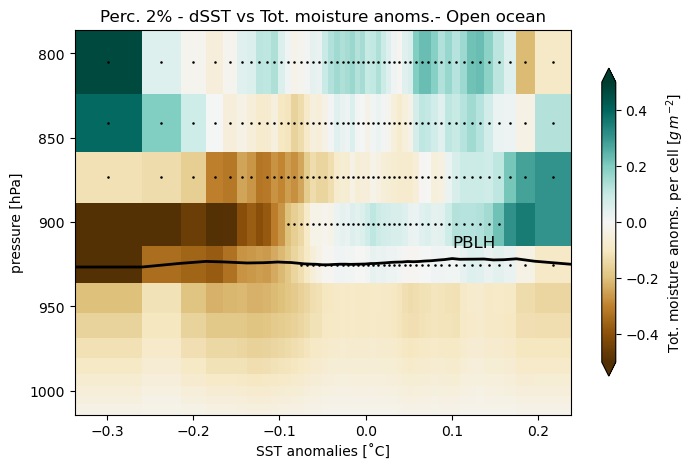

In [78]:
p_level_plot = int(15)

anoms = True
title = 'Perc. 2% - dSST vs Tot. moisture anoms.- Open ocean' if anoms else 'Perc 2% - SST vs Tot. moisture - Open ocean'
x = pdist_dsst if anoms else pdist_sst-273.15
var = pdist_dQVAPOR_day if anoms else pdist_QVAPOR_sst
minval = -0.5 if anoms else np.min(pdist_QVAPOR_sst)
maxval = -minval if anoms else 30

fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot], vmin=minval, vmax=maxval, cmap='BrBG') #BrBG
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title}')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8 , extend='both')
cbar.set_label(r'Tot. moisture anoms. per cell [$g\,m^{-2}$]')

var_pbl = pdist_PBLH_dsst if anoms else pdist_PBLH_sst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.1, 915, 'PBLH', fontsize=12, color='k')




# DEF punti significativi (pvalue < 0.05)
if anoms:
    pval = ppvalue_dQVAPOR_day_sub[0:p_level_plot] #if anoms else ppvalue_QVAPOR_dsst_sub[0:p_level_plot]
    GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
    signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
    dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
    for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
        cond1 = pval[h,:-1] > 0.05
        cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
        cond = (cond1) | (cond2)
    #     cond = cond1
        signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
        signif_Lcorr_H[h, cond] = GPbin[h]
        dsstbin[h,:] = x[1:] - np.diff(x)*0.5

    plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')




# savefig
path_img = '/venus/tesi_ale/img_EU/QVAPOR_correct/daily/FEB/' 
filename = path_img + 'NEW_pdist_dsst_dqMoisture_lowtropo_2pc_NEW.png' if anoms else path_img + 'NEW_pdist_sst_qMoisture_lowtropo_2pc_NEW.png'
# plt.savefig(filename)
print(filename)
del filename

In [68]:
#######   THIS IS TO FIND THE VALUES OF dQVAPOR AT THE LEVEL CLOSEST TO PBLH    #######


where = np.zeros_like(pdist_PBLH_dsst)

for i in range(0, len(pdist_PBLH_dsst)):
    dist = np.abs(mean_vert_pres - pdist_PBLH_dsst[i])
    min_dist = np.min(dist)
    where[i] = np.argwhere(dist==min_dist).astype(int)

qvapor_at_pblh = np.zeros_like(pdist_dsst)
error_at_pblh = np.zeros_like(pdist_dsst)
for i in range(0, len(pdist_dsst)):
    qvapor_at_pblh[i] = pdist_dQVAPOR_day[int(where[i]), i]
    error_at_pblh[i] = pstderr_dQVAPOR_day[int(where[i]), i]


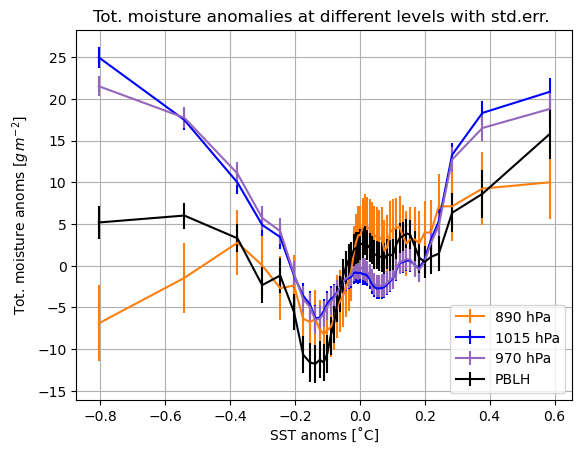

In [72]:
###  QVAPOR SCATTER AT DIFFERENT ALTITUDES  
plt.errorbar(pdist_dsst, pdist_dQVAPOR_day[11,:], yerr=pstderr_dQVAPOR_day[11,:], xerr=None,\
             label='890 hPa', ecolor='#ff7f0e', linestyle='-', color='#ff7f0e')

plt.errorbar(pdist_dsst, pdist_dQVAPOR_day[0,:], yerr=pstderr_dQVAPOR_day[0,:], xerr=None,\
             label='1015 hPa', ecolor='b', linestyle='-', color='b')

plt.errorbar(pdist_dsst, pdist_dQVAPOR_day[7,:], yerr=pstderr_dQVAPOR_day[7,:], xerr=None,\
             label='970 hPa', ecolor='#9467bd', linestyle='-', color='#9467bd')

plt.errorbar(pdist_dsst, qvapor_at_pblh, yerr=error_at_pblh, xerr=None,\
             label='PBLH', ecolor='k', linestyle='-', color='k')


# plt.errorbar(pdist_dsst, pdist_dQVAPOR_day[13,:]*1000, yerr=pstderr_dQVAPOR_day[13,:]*1000, xerr=None,\
#              label='825 hPa', ecolor='k', linestyle='-', color='k')

# plt.plot(pdist_dsst, qvapor_at_pblh*1000, '.-k', label='PBLH nrst')


# colors = {
#     'Forced HP': '#1f77b4',    # Blue
#     'Forced BP': '#ff7f0e',    # Orange
#     'Coupled HP': '#9467bd',   # Purple
#     'Coupled BP': '#17becf',   # Cyan
# }





plt.legend(loc='lower right')

plt.ylabel(r'Tot. moisture anoms [$g \, m^{-2}$]')
plt.xlabel('SST anoms [˚C]')
plt.title('Tot. moisture anomalies at different levels with std.err. ')
plt.grid()

# plt.savefig('/venus/tesi_ale/img_EU/QVAPOR_correct/daily/FEB/NEW_dqMoisture_levels_2%_withPBLH.png')



In [ ]:
#   CHECKING THE RH DISTRIBUTIONS, INSTEAD OF ABSOLUTE MOISTURE MAGNITUDES

In [10]:
# retrieve potential temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

# full pot_temp field
# = T+T0 , T0 = 300
pot_temp = pot_temp + 300

In [11]:
# compute actual temperature
# I DID NOT APPLY DAILY MEAN TO PRES!
temperature = pot_temp * ( pres / 1000. )**0.286
temperature = temperature.where(sea_mask_modified, drop=False)
del pot_temp

In [42]:
temp_day = temperature.groupby('time_counter.day').mean()

In [14]:
# my_save_data('/venus/tesi_ale/data_EU/T/daily/FEB/temp_day_feb.npy', [temp_day])

In [43]:
### compute daily temperature anomalies
s = 100
dT_day = np.zeros_like(temp_day)

for t in range(0,temp_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,temp_day.shape[1]):
        T_ave = gm.nan_gaussian_filter(temp_day[t,h],s)                             
        dT_day[t,h] = temp_day[t,h] - T_ave

0
10
20


In [16]:
my_save_data('/venus/tesi_ale/data_EU/T/daily/FEB/dTemp_day_feb.npy', [dT_day])

In [44]:
### compute perentile distributions
# COMPUTE PERCENTILE DISTRIBUTIONS

perc_step = 2
nbins = int(100/perc_step) # Number of bins.
popmean = 0.

pdist_dsst, pdist_dT, pstd_dT, pstderr_dT, pnpoints_dT, ppvalue_dT_sub = \
dist_3d_subsample(dsst_day, dT_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [48]:
### compute perentile distributions
# COMPUTE PERCENTILE DISTRIBUTIONS

perc_step = 2
nbins = int(100/perc_step) # Number of bins.
popmean = 0.

pdist_sst, pdist_T, pstd_T, pstderr_T, pnpoints_T, ppvalue_T_sub = \
dist_3d_subsample(sst_day, temp_day.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [25]:
with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_SST_day_feb.npy', 'rb') as f:
    miao = np.load(f)
    pdist_PBLH_sst = np.load(f)
    del miao
    f.close()

In [37]:
mean_vert_pres.shape

(39,)

/venus/tesi_ale/img_EU/T/daily/FEB/NEW_pdist_dsst_dT_lowtropo_dayfeb.png


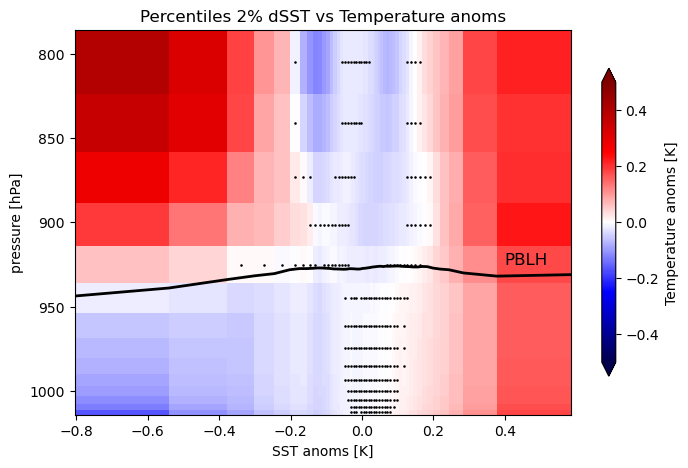

In [67]:
p_level_plot = int(15)

anoms = True

title = 'Percentiles 2% dSST vs Temperature anoms' if anoms else 'Percentiles 2% - SST vs Temperature'
xlabel = 'SST anoms [K]' if anoms else 'SST [˚C]' ; ylabel = 'pressure [hPa]'
cbar_lab = 'Temperature anoms [K]' if anoms else 'Temperature [˚C]'
cmap = 'seismic' if anoms else 'jet'

x = pdist_dsst if anoms else pdist_sst-273.15
var = pdist_dT if anoms else pdist_T-273.15
minval = -.5 if anoms else 15 ; maxval = -minval if anoms else 25.


fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot],\
                  vmin=minval, vmax=maxval, cmap=cmap)  #
ax1.set_xlabel(xlabel); ax1.set_ylabel(ylabel)
plt.title(f'{title}')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label(cbar_lab)


var_pbl = pdist_PBLH_dsst if anoms else pdist_PBLH_sst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.4, 925, 'PBLH', fontsize=12, color='k')


if anoms:
    # DEF punti significativi (pvalue < 0.05)
    pval = ppvalue_dT_sub[0:p_level_plot] #if perc else pvalue_drh_sub[0:p_level_plot]
    GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
    signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
    dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
    for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
        cond1 = pval[h,:-1] > 0.05
        cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
        cond = (cond1) | (cond2)
    #     cond = cond1
        signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
        signif_Lcorr_H[h, cond] = GPbin[h]
        dsstbin[h,:] = x[1:] - np.diff(x)*0.5

    ax1.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/T/daily/FEB/' if anoms else '/venus/tesi_ale/img_EU/T/daily/FEB/'
filename = path_img + 'NEW_pdist_dsst_dT_lowtropo_dayfeb.png' if anoms else path_img + 'NEW_pdist_sst_T_lowtropo_dayfeb.png'
# plt.savefig(filename)
print(filename)
del filename


In [13]:
#####  NOW APPLY DAILY MEAN TO PRES
# pres_day = pres.groupby('time_counter.day').mean()  #  

In [68]:
ds_RH = xr.open_dataset('/venus/tesi_ale/data_EU/RH/daily/FEB/RH.nc')
ds_RH

<xarray.Dataset>
Dimensions:       (day: 29, lat: 546, lon: 573, lev: 39, time_counter: 232)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2020-02-01T01:30:00 ... 2020-...
Dimensions without coordinates: day, lat, lon, lev
Data variables:
    rh2_day       (day, lat, lon) float64 ...
    rh_day        (day, lev, lat, lon) float64 ...
    rh_3h         (time_counter, lev, lat, lon) float64 ...
    rh2_3h        (time_counter, lat, lon) float64 ...

In [79]:
## load dRH
# rh_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh_day.npy')
drh_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/drh_day.npy')

In [81]:
drh_day = xr.DataArray(drh_day, name='drh_day', dims=['day', 'lev', 'lat', 'lon'])
drh_day.attrs['long name'] = 'mesoscale anomalies of daily RH, month of february'
drh_day.attrs['units'] = '%'



# xr.DataArray(list_vars[i], name=name_vars[i],dims=['day', 'lat', 'lon'])

In [82]:
ds_RH = ds_RH.assign(drh_day=drh_day)
ds_RH

<xarray.Dataset>
Dimensions:       (day: 29, lat: 546, lon: 573, lev: 39, time_counter: 232)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2020-02-01T01:30:00 ... 2020-...
Dimensions without coordinates: day, lat, lon, lev
Data variables:
    rh2_day       (day, lat, lon) float64 ...
    rh_day        (day, lev, lat, lon) float64 ...
    rh_3h         (time_counter, lev, lat, lon) float64 ...
    rh2_3h        (time_counter, lat, lon) float64 ...
    drh2_day      (day, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    drh_day       (day, lev, lat, lon) float64 nan nan nan nan ... nan nan nan

In [85]:
rh_day = ds_RH['rh_day'].values
drh_day = ds_RH['drh_day'].values

In [86]:
# correlation quantities

L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# ref mean
popmean = 0.

In [92]:
# COMPUTE PERCENTILE DISTRIBUTIONS
perc_step = 2
nbins = int(100/perc_step) # Number of bins.
popmean = 0.

pdist_sst, pdist_rh, pstd_rh, pstderr_rh, pnpoints_rh, ppvalue_rh_sub = \
dist_3d_subsample(sst_day, rh_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [91]:
# COMPUTE PERCENTILE DISTRIBUTIONS
perc_step = 2
nbins = int(100/perc_step) # Number of bins.
popmean = 0.

pdist_dsst, pdist_drh, pstd_drh, pstderr_drh, pnpoints_drh, ppvalue_drh_sub = \
dist_3d_subsample(dsst_day, drh_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


/venus/tesi_ale/img_EU/RH/daily/FEB/NEW_pdist_sst_rh_lowtropo_hatch.png


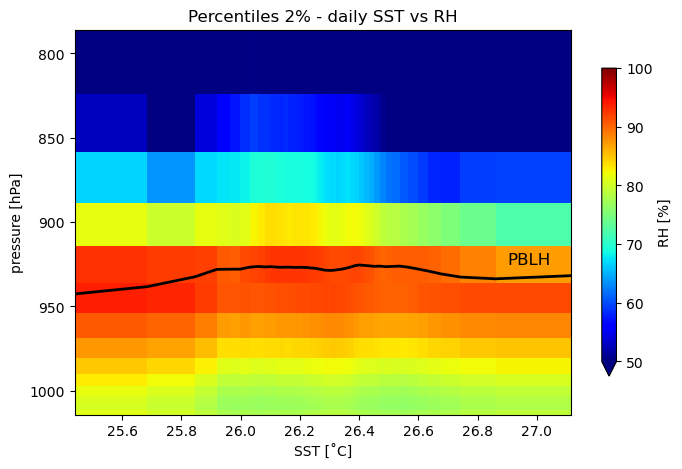

In [107]:
p_level_plot = int(15)

anoms = False
title = 'Percentiles 2% - daily dSST vs dRH' if anoms else 'Percentiles 2% - daily SST vs RH'
xlabel = 'SST anomalies [˚C]' if anoms else 'SST [˚C]'
cbar_lab = 'RH anoms [%]' if anoms else 'RH [%]'

x = pdist_dsst if anoms else pdist_sst-273.15
var = pdist_drh if anoms else pdist_rh
minval = -1.5 if anoms else 50 ; maxval = -minval if anoms else 100
#levs = np.arange(minval, maxval+0.1, 0.1)


fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot],\
                  vmin=minval, vmax=maxval, cmap='jet')  

ax1.set_xlabel(xlabel); ax1.set_ylabel('pressure [hPa]')
plt.title(title)
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='min')  
cbar.set_label(cbar_lab)

var_pbl = pdist_PBLH_dsst if anoms else pdist_PBLH_sst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(26.9, 925, 'PBLH', fontsize=12, color='k')



# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_drh_sub[0:p_level_plot] if anoms else ppvalue_rh_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/RH/daily/FEB/' if anoms else '/venus/tesi_ale/img_EU/RH/daily/FEB/'
filename = path_img + 'NEW_pdist_dsst_drh_lowtropo_hatch.png' if anoms else path_img + 'NEW_pdist_sst_rh_lowtropo_hatch.png'
# plt.savefig(filename)
print(filename)
del filename


In [109]:
#######   THIS IS TO FIND THE VALUES OF dRH AT THE LEVEL CLOSEST TO PBLH    #######


where = np.zeros_like(pdist_PBLH_dsst)

for i in range(0, len(pdist_PBLH_dsst)):
    dist = np.abs(mean_vert_pres - pdist_PBLH_dsst[i])
    min_dist = np.min(dist)
    where[i] = np.argwhere(dist==min_dist).astype(int)

drh_at_pblh = np.zeros_like(pdist_dsst_day)
drh_error_at_pblh = np.zeros_like(pdist_dsst_day)
for i in range(0, len(pdist_dsst_day)):
    drh_at_pblh[i] = pdist_drh[int(where[i]), i]
    drh_error_at_pblh[i] = pstderr_drh[int(where[i]), i]


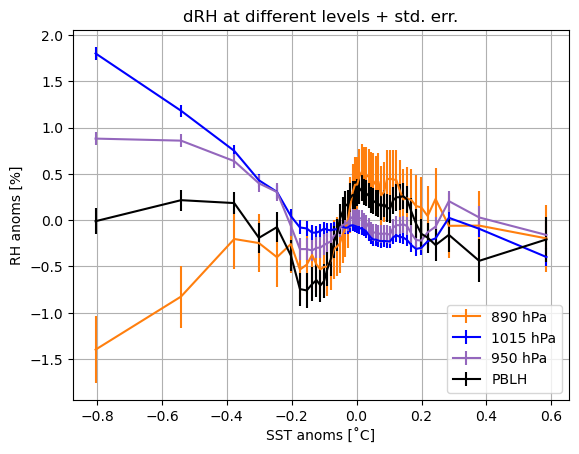

In [114]:

anoms = True

x = pdist_dsst if anoms else pdist_sst-273.15
y = pdist_drh if anoms else pdist_rh

plt.errorbar(x, y[11,:], yerr=pstderr_drh[11,:], xerr=None,\
             label='890 hPa', ecolor='#ff7f0e', linestyle='-', color='#ff7f0e')

plt.errorbar(x, y[0,:], yerr=pstderr_drh[0,:], xerr=None,\
             label='1015 hPa', ecolor='b', linestyle='-', color='b')

plt.errorbar(x, y[8,:], yerr=pstderr_drh[8,:], xerr=None,\
             label='950 hPa', ecolor='#9467bd', linestyle='-', color='#9467bd')

plt.errorbar(x, drh_at_pblh, yerr=drh_error_at_pblh, xerr=None,\
             label='PBLH', ecolor='k', linestyle='-', color='k')

plt.grid()
plt.legend(loc='lower right')

plt.ylabel('RH anoms [%]')
plt.xlabel('SST anoms [˚C]')
plt.title('dRH at different levels + std. err.')

# plt.savefig('/venus/tesi_ale/img_EU/RH/daily/FEB/NEW_dRH_single_levels.png')

In [11]:
##### study density of RH2
rh2_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh2_day.npy')
drh2_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/drh2_day.npy')

(array([2.22800e+03, 7.97500e+03, 1.63320e+04, 4.79240e+04, 1.15490e+05,
        1.89920e+05, 3.45589e+05, 5.04103e+05, 6.32329e+05, 7.36331e+05,
        7.44646e+05, 6.96755e+05, 6.00645e+05, 4.35941e+05, 3.17801e+05,
        2.03865e+05, 6.63590e+04, 2.37460e+04, 5.37700e+03, 5.33000e+02]),
 array([68.79738106, 69.93209918, 71.06681729, 72.2015354 , 73.33625352,
        74.47097163, 75.60568975, 76.74040786, 77.87512597, 79.00984409,
        80.1445622 , 81.27928032, 82.41399843, 83.54871654, 84.68343466,
        85.81815277, 86.95287089, 88.087589  , 89.22230711, 90.35702523,
        91.49174334]),
 <BarContainer object of 20 artists>)

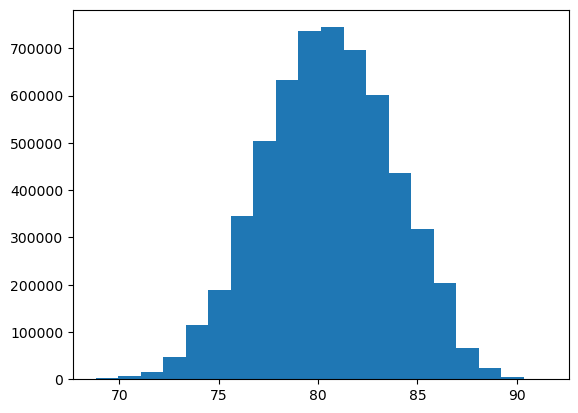

In [12]:
plt.hist(rh2_day[~np.isnan(rh2_day)], bins=20)

/venus/tesi_ale/img_EU/RH/daily/FEB/scatterFIT_dsst_dRH_feb.png


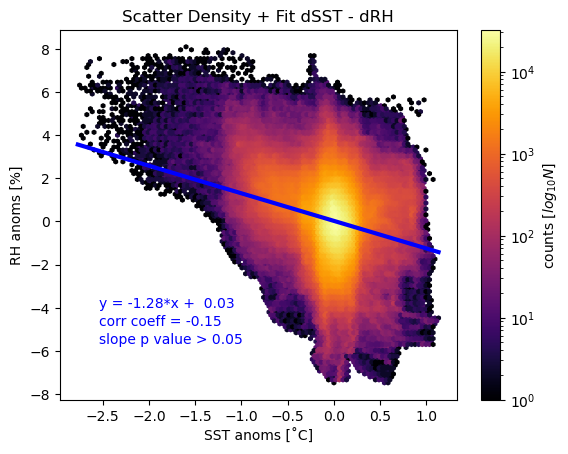

In [59]:
dsst = True

if not dsst:
    x =  (sst_day-273.15).copy()
    y =  rh2_day.copy()     
    fit, corcoe, p_value, p_value_cannelli, sigmas_full = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density + Fit SST - RH'
    xlabel='SST [˚C]'
    ylabel='RH [%]'
    
else:
    x = dsst_day.copy()    #dsst_day[~np.isnan(dsst_day)].copy()       #[::nt,::nskip,::nskip].copy()
    y = drh2_day.copy()         #dLH[~np.isnan(dLH)].copy()
    
    fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density + Fit dSST - dRH'
    xlabel='SST anoms [˚C]'
    ylabel='RH anoms [%]'
    '''miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1'''
    

fig = density_hexbin(x,y,fit=fit,corcoe=corcoe,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno')

'''if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)'''
    
if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.15), \
                         xycoords='axes fraction', fontsize=10, color='b')

    

path_img = '/venus/tesi_ale/img_EU/RH/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dRH_feb.png' if dsst else path_img + 'scatterFIT_sst_RH_feb.png'
#plt.savefig(filename)
print(filename)
del filename

In [6]:
ds_press_gph = xr.open_dataset('/venus/tesi_ale/data_EU/GPH/daily/FEB/GPH_3h_press.nc')
press_diff = ds_press_gph['press_diff']

In [7]:
ds_qsat = xr.open_dataset('/venus/tesi_ale/data_EU/QVAPOR/hourly/FEB/qsat_3h.nc')
qsat = ds_qsat['qsat']

In [8]:
sat_moisture_grams = (qsat*1000.)*press_diff/9.81

In [9]:
sat_moisture_grams_day = sat_moisture_grams.groupby('time_counter.day').mean()

In [11]:
sat_moisture_grams_day

<xarray.DataArray (day: 29, lev_M: 39, lat: 546, lon: 573)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 20 21 22 23 24 25 26 27 28 29
Dimensions without coordinates: lev_M, lat, lon

In [12]:
s = 100

dsat_moisture = np.zeros(sat_moisture_grams_day.shape)

for t in range(0,sat_moisture_grams_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,sat_moisture_grams_day.shape[1]):
        
        ave_moi = gm.nan_gaussian_filter(sat_moisture_grams_day[t,h].values,s) 
        dsat_moisture[t,h] = sat_moisture_grams_day[t,h].values - ave_moi

0
10
20


In [13]:
ds_out_sat = xr.Dataset()


dsat_moisture = xr.DataArray(dsat_moisture, name='dsat_moisture', dims=['day', 'lev_M', 'lat', 'lon'])
dsat_moisture.attrs['long name'] = 'daily anomalies 200km of grams/m2 of saturation moisture'
dsat_moisture.attrs['units'] = 'g/m2'
ds_out_sat = ds_out_sat.assign(dsat_moisture=dsat_moisture)

In [16]:
sat_moisture_grams.attrs['long name'] = '3h grams/m2 of saturation moisture'
sat_moisture_grams.attrs['units'] = 'g/m2'
ds_out_sat = ds_out_sat.assign(sat_moisture_grams=sat_moisture_grams)


sat_moisture_grams_day.attrs['long name'] = 'daily grams/m2 of saturation moisture'
sat_moisture_grams_day.attrs['units'] = 'g/m2'
ds_out_sat = ds_out_sat.assign(sat_moisture_grams_day=sat_moisture_grams_day)

In [18]:
ds_out_sat.to_netcdf('/venus/tesi_ale/data_EU/QVAPOR_correct/daily/FEB/saturation_moisture_grams.nc')

In [56]:
mask = open_ocean_mask  # open_ocean_mask  tourbillons_mask

In [57]:
# PERC DISTRIBUTION dQVAPOR vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dqsat, pstd_dqsat, pstderr_dqsat, pnpoints_dqsat, ppvalue_dqsat_sub = \
dist_3d_subsample(dsst_day*mask, dsat_moisture.values*mask, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [58]:
pdist_sst, pdist_qsat, pstd_qsat, pstderr_qsat, pnpoints_qsat, ppvalue_qsat_sub = \
dist_3d_subsample(sst_day*mask, sat_moisture_grams_day.values*mask, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [59]:
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstderr_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day*mask , PBLH_pres*mask, perc_step, nbins, popmean, perc_fixbin = 'perc')

pdist_sst, pdist_PBLH_sst, pstd_PBLH_sst, pstderr_PBLH_sst, pnpoints_PBLH_sst, ppvalue_PBLH_sst = \
distrib_2d(sst_day*mask, PBLH_pres*mask, perc_step, nbins, popmean, perc_fixbin = 'perc')

/venus/tesi_ale/img_EU/QVAPOR_correct/daily/FEB/NEW_pdist_dsst_dqSatMoisture_lowtropo_NEW.png


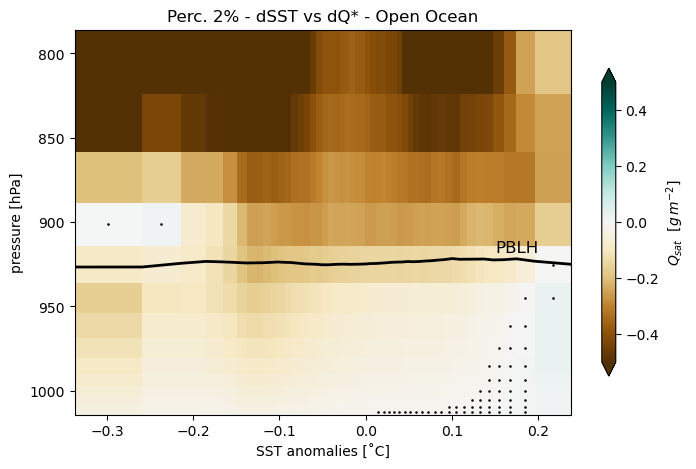

In [62]:
p_level_plot = int(15)

anoms = True
title = 'Perc. 2% - dSST vs dQ* - Open Ocean' if anoms else 'Perc. 2% - SST vs Q* - Open Ocean'
x = pdist_dsst if anoms else pdist_sst-273.15
var = pdist_dqsat if anoms else pdist_qsat
minval = -0.5 if anoms else 10. ; maxval = -minval if anoms else 50
#levs = np.arange(minval, maxval+0.1, 0.1)


fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot],\
                  vmin=minval, vmax=maxval, cmap='BrBG')  
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(title)
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('$Q_{sat}$  [$g\,m^{-2}$]')

var_pbl = pdist_PBLH_dsst if anoms else pdist_PBLH_sst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.15, 918, 'PBLH', fontsize=12, color='k')



# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dqsat_sub[0:p_level_plot] #if anoms else ppvalue_qsat_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/QVAPOR_correct/daily/FEB/'
filename = path_img + 'NEW_pdist_dsst_dqSatMoisture_lowtropo_NEW.png' if anoms else path_img + 'NEW_pdist_sst_qSatMoisture_lowtropo_NEW.png'
# plt.savefig(filename)
print(filename)
del filename